In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the data from CSV file
file_path = 'BTCUSD.csv'  # Update this to your actual file path
historical_data_df = pd.read_csv(file_path)

# Preprocess data
data = historical_data_df['close_price'].values.reshape(-1, 1)

# Exclude the last 100 points for separate scaling
last_100_points = data[-300:]
data_for_model = data[:-300]

# Scale the data for the model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_for_model)

# Create sequences
sequence_length = 10000 
sequences = []
next_price = []

for i in range(len(scaled_data) - sequence_length):
    sequences.append(scaled_data[i:i + sequence_length])
    next_price.append(scaled_data[i + sequence_length])

sequences = np.array(sequences)
next_price = np.array(next_price)

# Split the data into training and validation sets
split_index = int(0.80 * len(sequences))

X_train = sequences[:split_index]
y_train = next_price[:split_index]

# Build the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.01),
    LSTM(units=50),
    Dropout(0.01),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')




In [60]:
# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.1)




154/154 [==============================] - 2058s 13s/step - loss: 3.6158e-04 - val_loss: 1.2470e-04


In [61]:
model.save("LSTM_model.h5")

In [30]:
# Predicting the last 100 points using the model iteratively
predicted_prices = []
current_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)

# Predicting the last 100 points using the model iteratively
predicted_prices = []
current_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
for _ in range(300):
    # Predict the next step
    next_price_pred = model.predict(current_sequence)
    
    # Extract the single value from the prediction array
    next_price_scalar = next_price_pred[0, 0]  # Extract the scalar value
    
    # Append the predicted value to the list
    predicted_prices.append(next_price_scalar)
    
    # Update the sequence with the prediction
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[0, -1, 0] = next_price_scalar  # Use the scalar value

# Inverse transform the predicted prices to the original price scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))


1/1 [==============================] - 1s 553ms/step


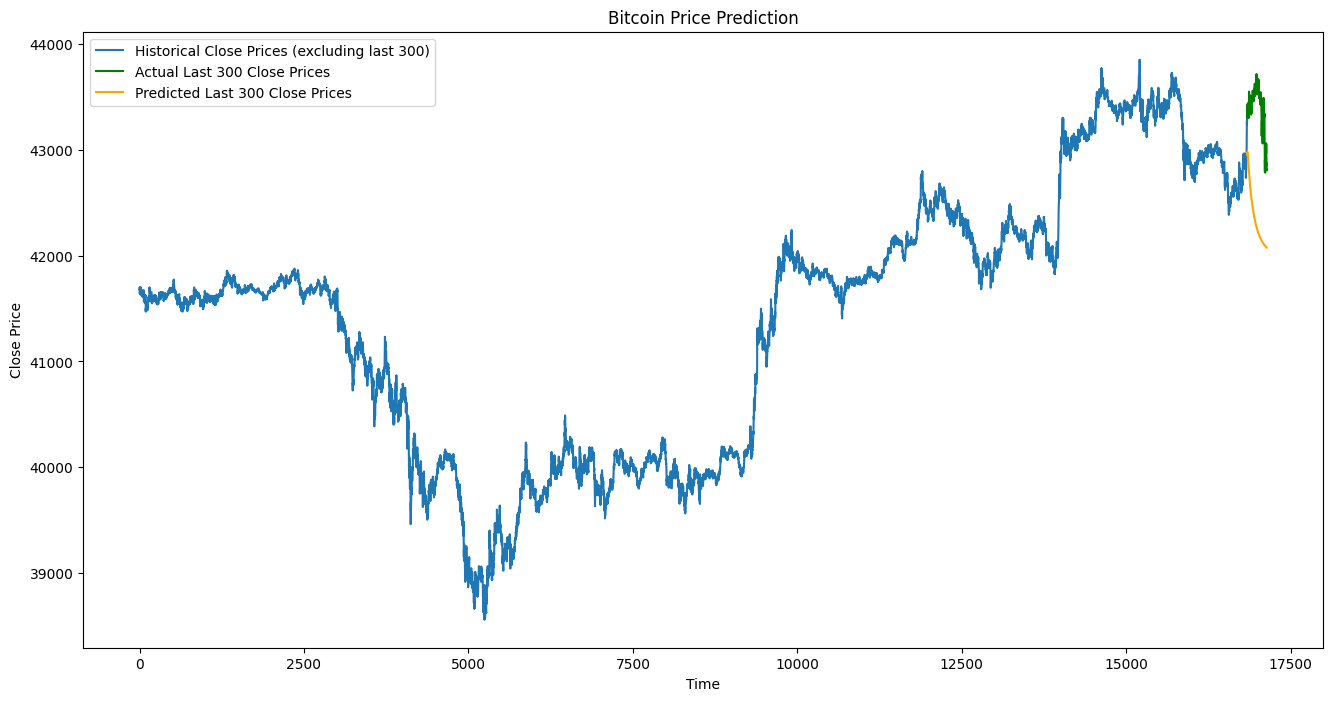

In [46]:
# Visualize the results
plt.figure(figsize=(16, 8))
# Plot historical close prices excluding the last 300 for clarity
plt.plot(historical_data_df['close_price'].values[:-300], label='Historical Close Prices (excluding last 300)')
# Plot the actual last 300 close prices
plt.plot(range(len(historical_data_df)-300, len(historical_data_df)), last_100_points[:300], label='Actual Last 300 Close Prices', color='green')
# Plot the predicted last 300 close prices
plt.plot(range(len(historical_data_df)-300, len(historical_data_df)), predicted_prices, label='Predicted Last 300 Close Prices', color='orange')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()
